In [1]:
import datetime
import pyaurorax
import matplotlib.pyplot as plt
import numpy as np

aurorax = pyaurorax.PyAuroraX()
at = aurorax.tools

# Working with TREx NIR calibrations

When working with narrow band image data such as TREx NIR and you'd like to convert the image to physical units (Rayleighs), there are various corrections and calibrations that need to be done. We as data providers, make available calibration files for each camera that help with this process. The calibrations are performed before the camera is deployed and after any major hardware repairs. For REGO, [this data tree](https://data.phys.ucalgary.ca/sort_by_project/TREx/NIR/calibration/) is where the files can be found, or you can use the tooling to download them.

There are three corrections and calibrations to do, where the order is important:
  1. Dark frame correction
  2. Flatfield correction
  3. Radiometric calibration

We're going to start by downloading a minute of TREx NIR data from Gillam.

In [2]:
# download a minute of TREx NIR data
dataset_name = "TREX_NIR_RAW"
dt = datetime.datetime(2021, 11, 4, 3, 30)
r = aurorax.data.ucalgary.download(dataset_name, dt, dt, site_uid="gill")

In [3]:
# read in the data
data = aurorax.data.ucalgary.read(r.dataset, r.filenames)

When it comes to calibrations for narrow-band imagers, the device unique identifier is used to get the correct calibration and correction files. This number is a unique ID for the detector used at that site, and they can move around different sites over the years of operating the instruments (primarily driven by repairs to the detectors).

The device UID is contained in the filenames and in the metadata. It's easiest to grab it from the metadata, so let's do that now.

In [4]:
# determine the device UID for this camera
device_uid = data.metadata[0]["Imager unique ID"]
print(f"Metadata field for 'Imager unique ID':\t{device_uid}")

# we just want the numbers, so we'll cut the starting character off
device_uid = device_uid[4:]
print(f"Device UID we'll use below:\t\t{device_uid}")

Metadata field for 'Imager unique ID':	nir-216
Device UID we'll use below:		216


In [5]:
# download rayleighs calibration for this device UID
dataset_name = "TREX_NIR_CALIBRATION_RAYLEIGHS_IDLSAV"
r = aurorax.data.ucalgary.download_best_rayleighs_calibration(dataset_name, device_uid, dt)
r.filenames

[PosixPath('/home/darrenc/pyaurorax_data/TREX_NIR_CALIBRATION_RAYLEIGHS_IDLSAV/NIR_Rayleighs_23216_20210819-+_v02.sav')]

In [6]:
# read in the rayleighs calibration file
data_cal_rayleighs = aurorax.data.ucalgary.read(r.dataset, r.filenames[0])
data_cal_rayleighs.data[0].pretty_print()

Calibration:
  dataset                    : Dataset(...)
  detector_uid               : 23216
  filename                   : NIR_Rayleighs_23216_20210819-+_v02.sav
  flat_field_multiplier      : None
  generation_info            : CalibrationGenerationInfo(...)
  rayleighs_perdn_persecond  : 12.777938395844197
  version                    : v02


In [7]:
# download flatfield calibration for this device UID
dataset_name = "TREX_NIR_CALIBRATION_FLATFIELD_IDLSAV"
r = aurorax.data.ucalgary.download_best_flatfield_calibration(dataset_name, device_uid, dt)
r.filenames

[PosixPath('/home/darrenc/pyaurorax_data/TREX_NIR_CALIBRATION_FLATFIELD_IDLSAV/NIR_flatfield_23216_20210819-+_v02.sav')]

In [8]:
# read in the flatfield calibration file
data_cal_flatfield = aurorax.data.ucalgary.read(r.dataset, r.filenames[0])
data_cal_flatfield.data[0].pretty_print()

Calibration:
  dataset                    : Dataset(...)
  detector_uid               : 23216
  filename                   : NIR_flatfield_23216_20210819-+_v02.sav
  flat_field_multiplier      : array(dims=(256, 256), dtype=>f8)
  generation_info            : CalibrationGenerationInfo(...)
  rayleighs_perdn_persecond  : None
  version                    : v02


# Apply dark frame correction

Now that we have all the data we need to continue, let's next apply the dark frame correction. The correction is done by subtracting an average of a bottom corner grid from the image (ie. 4x4.).

In [9]:
# apply dark frame calibration
#
# NOTE: by default, each of the 'step_XXXX' functions are true. We are explicitly
# setting them here just to illustrate how each step would be done
#
# NOTE: we are going to apply the correction to all frames we loaded. You can limit
# it however you'd like (ie. data.data[:, :, frame_num], or data.data[:, :, frame_num_start:frame_num_end, etc.)
calibrated_data = at.calibration.trex_nir(
    data.data,
    step_dark_frame_correction=True,
    step_flatfield_calibration=False,
    step_rayleighs_calibration=False,
)
print(calibrated_data.shape)

(256, 256, 10)


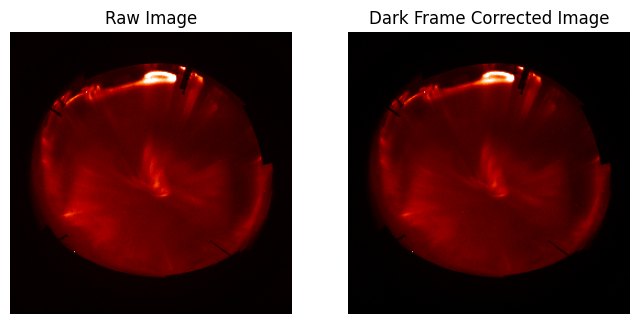

In [10]:
# show the raw image on the left, and the dark frame corrected image on the right
#
# NOTE: we're going to display only the first frame of data (we loaded in 1 minute
# of data, which has 10 frames; every 6 seconds)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.set_title("Raw Image")
ax1.imshow(at.scale_intensity(data.data[:, :, 0], min=0, max=4000), cmap="gist_heat", origin="lower")
ax1.axis("off")

ax2.set_title("Dark Frame Corrected Image")
ax2.imshow(at.scale_intensity(calibrated_data[:, :, 0], min=0, max=4000), cmap="gist_heat", origin="lower")
ax2.axis("off")

plt.show()

# Apply flatfield correction

The flat field array is essentially a multiplicative array to be applied to the image. You'll notice that at low elevation angles, this factor is higher (which is expected).


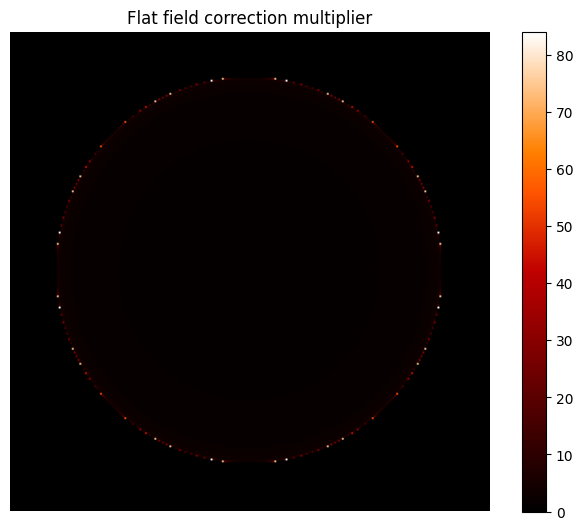

In [11]:
# let's display the flat field correction multiplier just to illustrate what
# it looks like
at.display(
    data_cal_flatfield.data[0].flat_field_multiplier,
    cmap="gist_heat",
    title="Flat field correction multiplier",
    colorbar=True,
)

In [12]:
# apply the flatfield calibration
#
# NOTE: since the 'step_XXXX' parameters are true by default, we are actually doing
# the flatfield calibration AND the dark frame correction all at once here.
calibrated_data = at.calibration.trex_nir(data.data, cal_flatfield=data_cal_flatfield.data[0], step_rayleighs_calibration=False)
print(calibrated_data.shape)

(256, 256, 10)


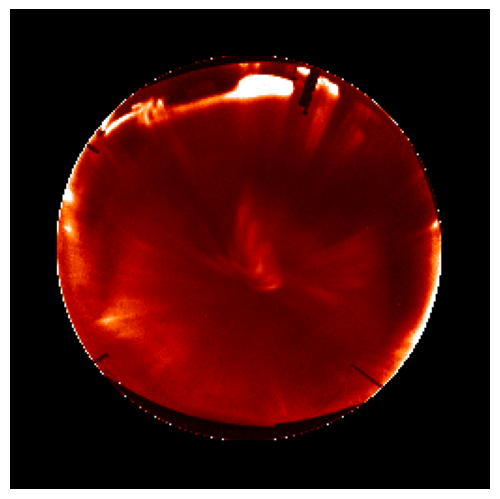

In [13]:
# display the first frame of data with the dark frame and flatfield corrections applied
at.display(at.scale_intensity(calibrated_data[:, :, 0], min=0, max=4000), cmap="gist_heat")

# Apply Rayleighs conversion

Finally, we're going to apply the calibration to convert to Rayleighs.

In [14]:
# apply ALL THREE of the tasks: dark frame correction, flat field correction, AND the Rayleighs calibration
#
# NOTE: remember that the 'step_XXXX' parameters are true by default. So since we are
# going to do all three steps at once, we are omitting them from the call and therefore
# they will all be true.
calibrated_data = at.calibration.trex_nir(
    data.data,
    cal_flatfield=data_cal_flatfield.data[0],
    cal_rayleighs=data_cal_rayleighs.data[0],
)
print(calibrated_data.shape)

(256, 256, 10)


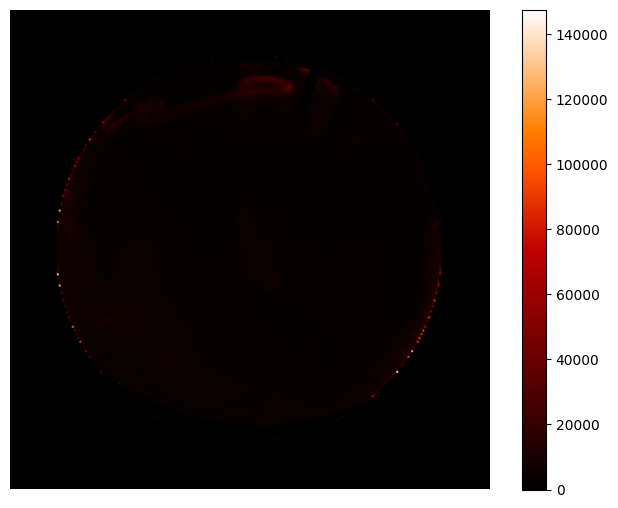

In [15]:
# display the first frame of calibrated and corrected data
#
# NOTE: you'll see that we don't scale this image. Read lower to see the catch with it.
at.display(calibrated_data[:, :, 0], cmap="gist_heat", colorbar=True)

We could benefit from some scaling here since it's a bit dim. If you want to scale the calibrated data, we can do that, but make sure you realize what this is actually doing.

We can put a max value of, say, 15000 Rayleighs on the array, but we MUST account for that in the colorbar. By applying a scaling ceiling to the data, it means that any image pixel with a maximum value could be actually be greater than that ceiling, which physically, is important to realize.

When scaling multiple imagers, and/or in a time sequence, it is essential to ensure that scaling is not introducing information into the data (e.g., scaling images differently as a function of time). This statement is especially important when generating mosaics of calibrated data.

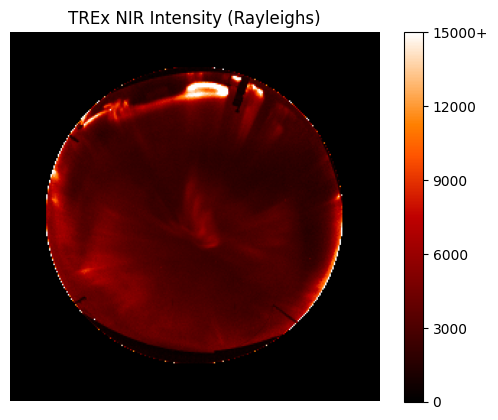

In [16]:
# cap the scale at a certain Rayleighs
max_cutoff = 15000
calibrated_data[np.where(calibrated_data > max_cutoff)] = max_cutoff

# plot the data
plt.imshow(calibrated_data[:, :, 0], cmap="gist_heat", vmin=0, vmax=max_cutoff, origin="lower")
plt.axis("off")
plt.title("TREx NIR Intensity (Rayleighs)")

# create a colorbar in Rayleighs that accounts for the scaling limit we applied
cbar_ticks = [float(max_cutoff) / 5. * j for j in range(0, 6)]
cbar_ticknames = [str(int(max_cutoff / 5) * j) for j in range(0, 6)]

# any pixels with the max Rayleigh value could be greater than it, so we include the plus sign
cbar_ticknames[-1] += '+'
cbar = plt.colorbar(ticks=cbar_ticks)
cbar.ax.set_yticklabels(cbar_ticknames)

# show the plot
plt.show()